## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

The goal of this post is to walk you through the steps to create and train an AI deep learning neural network for anomaly detection using Python, Keras and TensorFlow. 

**Analysis Dataset**

We will use vibration sensor readings from the NASA Acoustics and Vibration Database as our dataset for this study. In the NASA study, sensor readings were taken on four bearings that were run to failure under constant load over multiple days. Our dataset consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points per bearing that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

**Anomaly Detection**

Anomaly detection is the task of determining when something has gone astray from the “norm”. Anomaly detection using neural networks is modeled in an unsupervised / self-supervised manner; as opposed to supervised learning, where there is a one-to-one correspondence between input feature samples and their corresponding output labels. The presumption is that normal behavior, and hence the quantity of available “normal” data, is the norm and that anomalies are the exception to the norm to the point where the modeling of “normalcy” is possible.
We will use an autoencoder deep learning neural network model to identify vibrational anomalies from the sensor readings. The goal is to predict future bearing failures before they happen.

In [6]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import joblib

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [7]:
# set random seed
seed(10)
tensorflow.random.set_seed(10)

# Data loading and pre-processing


The assumption is that the mechanical degradation in the bearings occurs gradually over time; therefore, we will use one datapoint every 10 minutes in our analysis. Each 10 minute data file sensor reading is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints. We then merge everything together into a single Pandas dataframe.


In [14]:
# load, average and merge sensor samples
data_dir = 'Sensor Data/bearing_data/Bearing_Sensor_Data_pt1'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [15]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [16]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


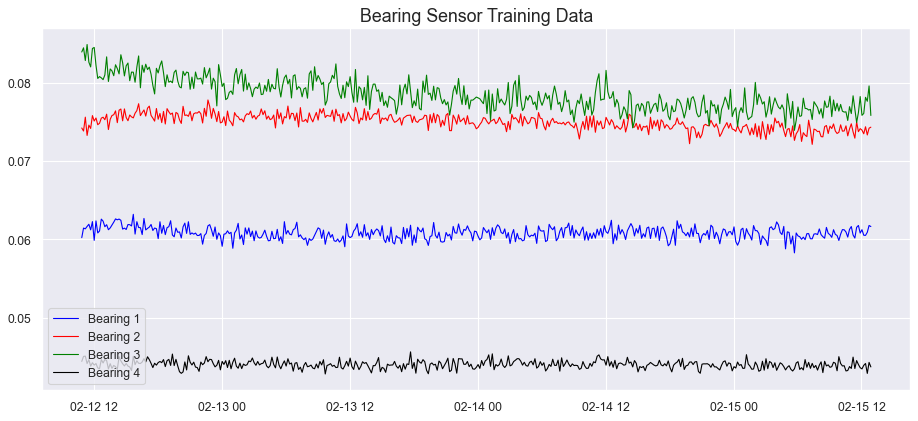

In [17]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [18]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

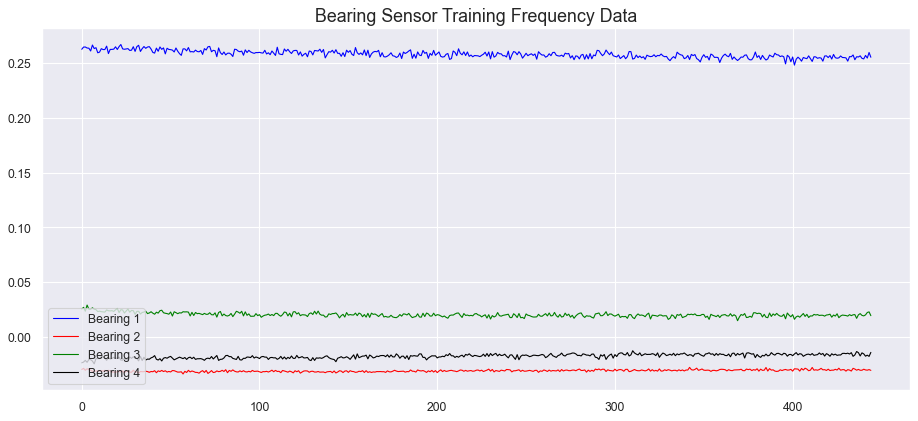

In [19]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

There is nothing notable about the normal operational sensor readings. Now, let’s look at the sensor frequency readings leading up to the bearing failure.

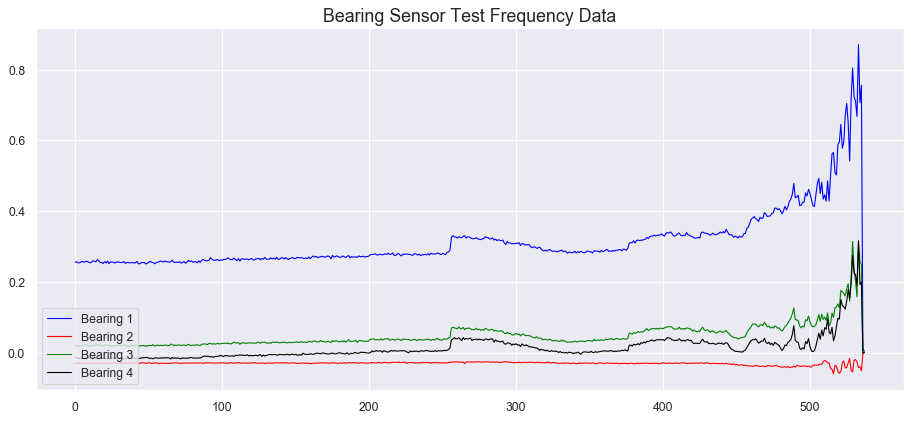

In [10]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

We can clearly see an increase in the frequency amplitude and energy in the system leading up to the bearing failures.
To complete the pre-processing of our data, we will first normalize it to a range between 0 and 1. Then we reshape our data into a format suitable for input into an LSTM network. LSTM cells expect a 3 dimensional tensor of the form [data samples, time steps, features]. Here, each sample input into the LSTM network represents one step in time and contains 4 features — the sensor readings for the four bearings at that time step.

In [20]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [21]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


One of the advantages of using LSTM cells is the ability to include multivariate features in your analysis. Here, it’s the four sensor readings per time step. However, in an online fraud anomaly detection analysis, it could be features such as the time of day, dollar amount, item purchased, internet IP per time step.

**LSTM Networks** 

The concept for this study was taken in part from an excellent article by Dr. Vegard Flovik “Machine learning for anomaly detection and condition monitoring”. In that article, the author used dense neural network cells in the autoencoder model. Here, we will use Long Short-Term Memory (LSTM) neural network cells in our autoencoder model. LSTM networks are a sub-type of the more general recurrent neural networks (RNN). A key attribute of recurrent neural networks is their ability to persist information, or cell state, for use later in the network. This makes them particularly well suited for analysis of temporal data that evolves over time. LSTM networks are used in tasks such as speech recognition, text translation and here, in the analysis of sequential sensor readings for anomaly detection.

We will use an autoencoder neural network architecture for our anomaly detection model. The autoencoder architecture essentially learns an “identity” function. It will take the input data, create a compressed representation of the core / primary driving features of that data and then learn to reconstruct it again. For instance, input an image of a dog, it will compress that data down to the core constituents that make up the dog picture and then learn to recreate the original picture from the compressed version of the data.

The rationale for using this architecture for anomaly detection is that we train the model on the “normal” data and determine the resulting reconstruction error. Then, when the model encounters data that is outside the norm and attempts to reconstruct it, we will see an increase in the reconstruction error as the model was never trained to accurately recreate items from outside the norm.

We create our autoencoder neural network model as a Python function using the Keras library.

In [22]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In the LSTM autoencoder network architecture, the first couple of neural network layers create the compressed representation of the input data, the encoder. We then use a repeat vector layer to distribute the compressed representational vector across the time steps of the decoder. The final output layer of the decoder provides us the reconstructed input data.
We then instantiate the model and compile it using Adam as our neural network optimizer and mean absolute error for calculating our loss function.

In [23]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              68    

In [24]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 32s 73ms/step - loss: 0.4595 - val_loss: 0.3190
Epoch 2/100
43/43 [==============================] - 1s 33ms/step - loss: 0.3925 - val_loss: 0.2455
Epoch 3/100
43/43 [==============================] - 1s 29ms/step - loss: 0.3224 - val_loss: 0.1621
Epoch 4/100
43/43 [==============================] - 1s 30ms/step - loss: 0.1917 - val_loss: 0.1684
Epoch 5/100
43/43 [==============================] - 1s 29ms/step - loss: 0.1218 - val_loss: 0.1404
Epoch 6/100
43/43 [==============================] - 1s 29ms/step - loss: 0.1063 - val_loss: 0.1225
Epoch 7/100
43/43 [==============================] - 1s 28ms/step - loss: 0.1023 - val_loss: 0.1146
Epoch 8/100
43/43 [==============================] - 1s 29ms/step - loss: 0.1052 - val_loss: 0.1138
Epoch 9/100
43/43 [==============================] - 1s 29ms/step - loss: 0.1016 - val_loss: 0.1151
Epoch 10/100
43/43 [==============================] - 1s 31ms/step - loss: 0.1013 - val_loss: 0.113

43/43 [==============================] - 1s 32ms/step - loss: 0.0913 - val_loss: 0.0936
Epoch 83/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0961 - val_loss: 0.0935
Epoch 84/100
43/43 [==============================] - 1s 31ms/step - loss: 0.0969 - val_loss: 0.0926
Epoch 85/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0917 - val_loss: 0.0925
Epoch 86/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0940 - val_loss: 0.0944
Epoch 87/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0911 - val_loss: 0.0928
Epoch 88/100
43/43 [==============================] - 1s 31ms/step - loss: 0.0966 - val_loss: 0.0927
Epoch 89/100
43/43 [==============================] - 3s 71ms/step - loss: 0.0935 - val_loss: 0.0929
Epoch 90/100
43/43 [==============================] - 1s 27ms/step - loss: 0.0907 - val_loss: 0.0925
Epoch 91/100
43/43 [==============================] - 1s 32ms/step - loss: 0.0941 - val_loss: 0.0918
Epo

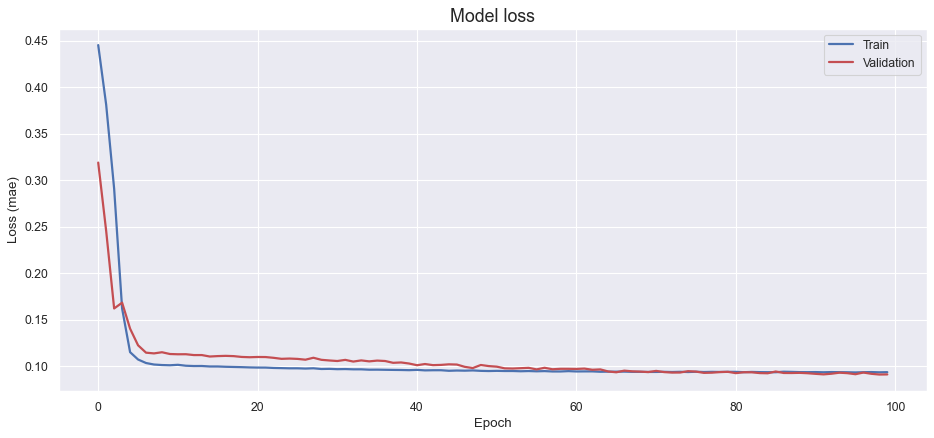

In [25]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

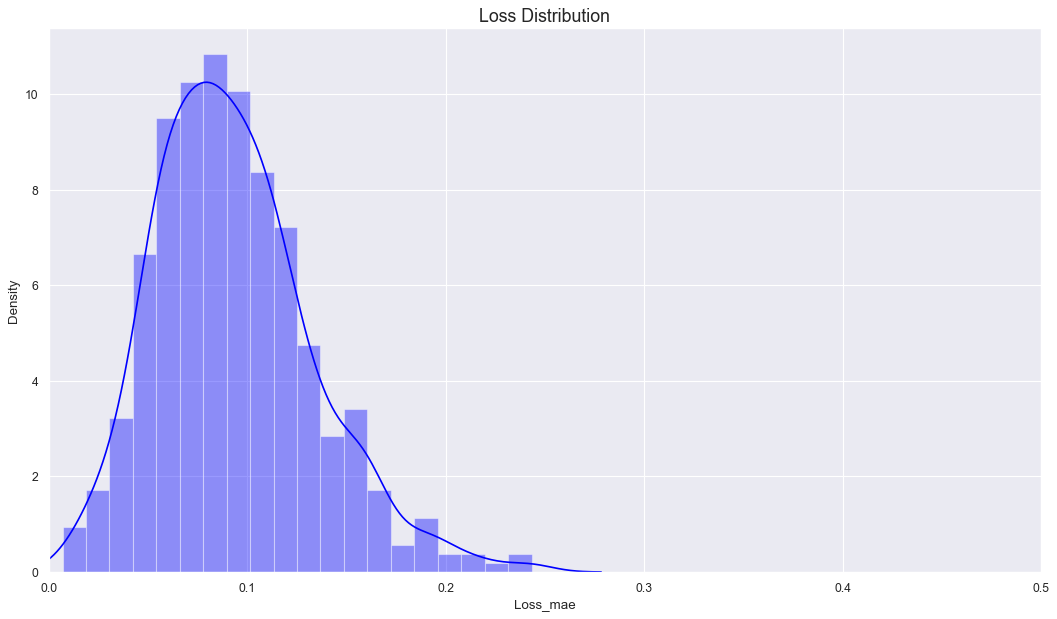

In [26]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [27]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094939,0.275,False
2004-02-15 13:02:39,0.171356,0.275,False
2004-02-15 13:12:39,0.069473,0.275,False
2004-02-15 13:22:39,0.051763,0.275,False
2004-02-15 13:32:39,0.039227,0.275,False


In [29]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [30]:
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-12 10:52:39,0.215299,0.275,False
2004-02-12 11:02:39,0.243271,0.275,False
2004-02-12 11:12:39,0.119537,0.275,False
2004-02-12 11:22:39,0.241161,0.275,False
2004-02-12 11:32:39,0.165024,0.275,False


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

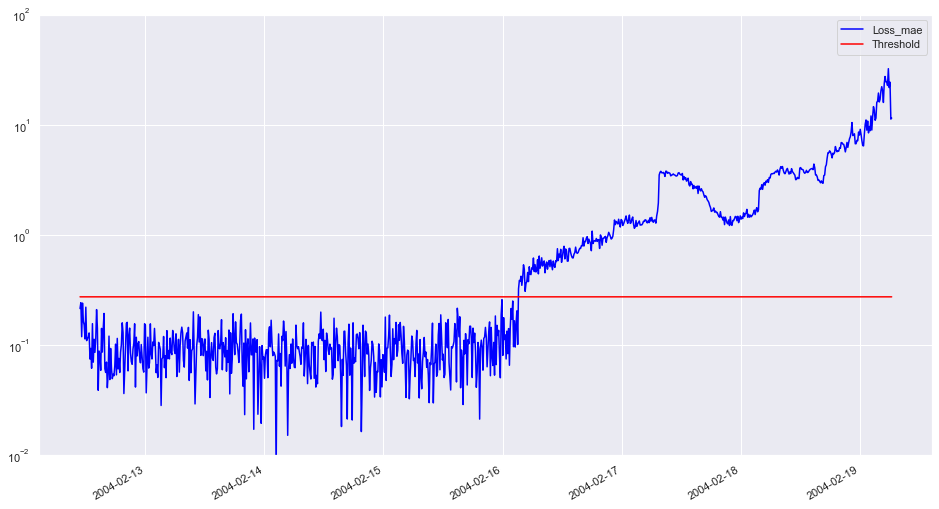

In [31]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [32]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
